# Digt Recognizer

For starters lets build a CNN classifier.
This model produces around 97% Accuracy. But I will work it to push the accuracy and update here in this repo.

In [1]:
import pandas as pd
import numpy as np
from keras import layers as layer
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test = pd.read_csv('test.csv')
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def prepare_data():
    X = train.iloc[:,[x for x in range(1,785)]] #filter all columns except column label
    X = X.values # get as numpy array of shape 42000,784
    X = X/255
    X = X.reshape(X.shape[0],28,28,1) # 42000,28,28
    y = train.iloc[:,[0]].values # shape 42000,1
    y =  to_categorical(y)
    return X,y

In [5]:
X,y = prepare_data()
print(X.shape,y.shape)

(42000, 28, 28, 1) (42000, 10)


####  NOTE: tf layers conv2d input shape should be (batch_size, img_size, img_size, 1)

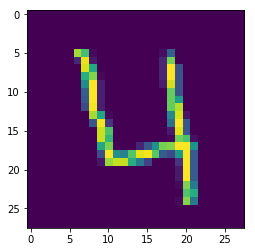

In [6]:
plt.imshow(X[3].reshape(28,28))

In [7]:
print(np.argmax(y[3]))

4


#### 4th sample is number 4.

In [8]:
#Prepare Test data for submission

x_sub = test.values
x_sub = x_sub/255
x_sub = x_sub.reshape(x_sub.shape[0],28,28,1) # 20000,28,28
x_sub.shape


(28000, 28, 28, 1)

In [9]:
num_classes = 10
learning_rate = 0.005
epochs = 10
batch_size = 64
img_size = 28 #28 X 28

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(41580, 28, 28, 1) (41580, 10) (420, 28, 28, 1) (420, 10)


In [11]:
# In case if our model use random mini-batch and SGD 
class BatchGenerator():
    def __init__(self, batch_size,X,y):
        self.batch_size = batch_size
        self.X  = X
        self.y = y
        
    def next(self):
        idx = np.arange(0 , X.shape[0])
        np.random.shuffle(idx)
        idx = idx[:batch_size]
        X_shuffle = [X[ i] for i in idx]
        y_shuffle = [y[ i] for i in idx]

        return np.asarray(X_shuffle), np.asarray(y_shuffle)
    
        

In [12]:
def batches_generator(batch_size, X, y,
                      shuffle=True, allow_smaller_last_batch=True):
    """Generates padded batches of tokens and tags."""
    
    n_samples = X.shape[0]
    if shuffle:
        order = np.random.permutation(n_samples)
    else:
        order = np.arange(n_samples)

    n_batches = n_samples // batch_size
    if allow_smaller_last_batch and n_samples % batch_size:
        n_batches += 1
        
    X_shuffle = X[order,:,:,:]
    y_shuffle = y[order,]
    for k in range(n_batches):
        batch_start = k * batch_size
        batch_end = min((k + 1) * batch_size, n_samples)
        current_batch_size = batch_end - batch_start
        batch_x = X_shuffle[batch_start:batch_end]
        batch_y = y_shuffle[batch_start:batch_end]
        
        yield batch_x, batch_y

In [13]:
tf.reset_default_graph()

In [14]:
class CNNModel():
    
    def __init__(self):
        self.build_model()
        self.loss_prediction()
        self.optimizer()
        
        
        
    
    def build_model(self):
        
        self.input_x = tf.placeholder(dtype=tf.float32,shape=[None,img_size,img_size,1], name='input_x')
        self.labels = tf.placeholder(dtype=tf.float32,shape=[None,10], name="label")
        self.keep_prob =  tf.placeholder_with_default(tf.cast(1.0, tf.float32), shape=[])
        
        conv1 = tf.layers.conv2d(self.input_x,filters=8,kernel_size=[3,3], padding='same',
                                activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
        pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=[2,2], strides=2)
        
        
        conv2 = tf.layers.conv2d(pool1,filters=16,kernel_size=[5,5], padding='same',
                                activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
        pool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=[2,2], strides=2)
        
        conv3 = tf.layers.conv2d(pool2,filters=120,kernel_size=[5,5], padding='same',
                                activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
        pool3 = tf.layers.max_pooling2d(inputs=conv3,pool_size=[2,2], strides=2)
        
        dropout_1 = tf.nn.dropout(pool3,self.keep_prob)
        
       
        flattened =  tf.layers.flatten(dropout_1)
        
        dense1 =  tf.layers.dense(inputs=flattened, units=120, activation=tf.nn.relu, kernel_initializer=tf.initializers.truncated_normal,
                                  kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=0.1))
        
        dense2 =  tf.layers.dense(inputs=dense1, units=120, activation=tf.nn.relu, kernel_initializer=tf.initializers.truncated_normal,
                                  kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=0.1))
        
        self.logits =  tf.layers.dense(inputs=dense2, units=10)
        
    def loss_prediction(self):
        self.y_hat  = tf.nn.softmax(self.logits)
        self.prediction = tf.argmax(self.y_hat,1)
        correct_prediction = tf.equal(self.prediction, tf.argmax(self.labels,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.labels))
        
    def optimizer(self):
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        
    def train_batch(self, sess, batch_x, batch_y, dropout_keep_prob):
        _, loss_val =  sess.run([self.train_op,self.loss], feed_dict= {
           self.input_x:batch_x,
           self.labels:batch_y,
           self.keep_prob:dropout_keep_prob
       })
        return _,loss_val
    def get_accuracy(self, sess, batch_x, batch_y):
        acc_val = sess.run(self.accuracy, feed_dict= { self.input_x:batch_x, self.labels:batch_y, 
                                                      self.keep_prob: 1.0})
        return acc_val
    def predict(self,sess,batch_x):
        prediction = sess.run(self.prediction, feed_dict={
            self.input_x:batch_x,
            self.keep_prob: 1.0
        })
        return prediction
        
    def save(self,sess):
        self.saver = tf.train.Saver()
        self.model_dir = 'tfmodel/my-model'
        self.saver.save(sess,self.model_dir)
    
    def load2(self, sess):
        latest_checkpoint = tf.train.latest_checkpoint(self.model_dir)
        if latest_checkpoint:
            print("Loading model checkpoint {} ...\n".format(latest_checkpoint))
            self.saver.restore(sess, latest_checkpoint)
            print("Model loaded")
    def load(self,sess):
        new_saver = tf.train.import_meta_graph(self.model_dir+'.meta')
        new_saver.restore(sess, self.model_dir)

In [15]:
model = CNNModel()

In [16]:
sess = tf.Session()

In [17]:
sess.run(tf.global_variables_initializer())
total_batch = X_train.shape[0] / batch_size
for epoch in range(epochs):
    avg_loss = 0
    #batch_x, batch_y = batch_generator.next()
    for batch_x,batch_y in batches_generator(batch_size,X_train,y_train):
        _, loss_val  = model.train_batch(sess,batch_x=batch_x, batch_y=batch_y, dropout_keep_prob=0.7)
        avg_loss += loss_val / total_batch
    
    acc_val = model.get_accuracy(sess,X_test,y_test)
    print('Test set Accuaracy Epoch %d, loss %f accuracy %f' % (epoch+1, avg_loss, acc_val))

    
    
    

Test set Accuaracy Epoch 1, loss 0.483163 accuracy 0.947619
Test set Accuaracy Epoch 2, loss 0.193766 accuracy 0.961905
Test set Accuaracy Epoch 3, loss 0.158955 accuracy 0.969048
Test set Accuaracy Epoch 4, loss 0.134940 accuracy 0.971429
Test set Accuaracy Epoch 5, loss 0.123699 accuracy 0.969048
Test set Accuaracy Epoch 6, loss 0.122235 accuracy 0.973810
Test set Accuaracy Epoch 7, loss 0.108522 accuracy 0.978571
Test set Accuaracy Epoch 8, loss 0.103261 accuracy 0.973810
Test set Accuaracy Epoch 9, loss 0.102964 accuracy 0.959524
Test set Accuaracy Epoch 10, loss 0.099427 accuracy 0.971429


Since I m getting resource exhausted error for 28k test data in my machine, I m batching the prediction as well.

In [18]:
y_sub = np.array([])
batch = 1000
total_batch = int(x_sub.shape[0] / batch)
for i in range(total_batch):
    start = i * 1000
    end = i* 1000 + batch
    sliced = x_sub[start:end]
    pred = model.predict(sess, sliced)
    y_sub = np.append(y_sub,np.array(pred))


In [19]:
sess.close()

In [20]:
test_pred = pd.DataFrame({'ImageId':test.index+1,'Label':y_sub.astype(int)})
test_pred.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


### Lets compare our prediction

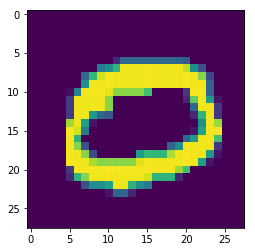

In [21]:
plt.imshow(x_sub[1].reshape(28,28))

In [169]:
#test_pred.to_csv('submission.csv',index=False)